### Reading in Data

In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn

In [7]:
dataset = pd.read_csv('blin_interactions.csv', na_filter=False)
#only look at comments and tags
dataset = dataset[['Interaction Territory Country', 'Interaction Dt', 'Hcp Feedback', 'Hcp Comments', 'Hcp Insight', 'Actionable']]
dataset.head()

,Interaction Territory Country,Interaction Dt,Hcp Feedback,Hcp Comments,Hcp Insight,Actionable
0,BeLux,5/31/2021,Vedefar - pump support,Vedefar - pump support,,
1,Bulgaria,1/13/2020,ALL Assembly 2020 - details sent,ALL Assembly 2020 - details sent,,
2,Bulgaria,1/14/2020,Blincyto Regulatory training,Blincyto Regulatory training,,
3,Bulgaria,1/27/2020,ALL Assembly 2020 - certificate of attendance ...,ALL Assembly 2020 - certificate of attendance ...,,
4,Bulgaria,1/27/2020,ALL Assembly 2020 - certificate of attendance ...,ALL Assembly 2020 - certificate of attendance ...,,


In [8]:
#combine redundant columns, 15-17

for i in range(0, len(dataset)):
    comment = str(dataset['Hcp Feedback'][i])
    if not comment:
        if dataset['Hcp Comments'][i]:
            dataset['Hcp Feedback'][i] = dataset['Hcp Comments'][i]
        else:
            dataset['Hcp Feedback'][i] = dataset['Hcp Insight'][i]

dataset.pop('Hcp Comments')
dataset.pop('Hcp Insight')
print(dataset)

     Interaction Territory Country Interaction Dt  \
0                            BeLux      5/31/2021   
1                         Bulgaria      1/13/2020   
2                         Bulgaria      1/14/2020   
3                         Bulgaria      1/27/2020   
4                         Bulgaria      1/27/2020   
...                            ...            ...   
7684                            US       3/9/2021   
7685                            US      3/24/2021   
7686                            US      3/26/2021   
7687                            US       4/1/2021   
7688                            US       6/9/2021   

                                           Hcp Feedback Actionable  
0                                Vedefar - pump support             
1                      ALL Assembly 2020 - details sent             
2                          Blincyto Regulatory training             
3     ALL Assembly 2020 - certificate of attendance ...             
4     ALL Assembly

In [9]:
#If not actionable or empty, tag as 0, else 1

for i in range(0, len(dataset)):
    if dataset['Actionable'][i] == 'y':
        dataset['Actionable'][i] = 1
    else:
        dataset['Actionable'][i] = 0

In [10]:
# check class distribution of actionable
act_classes = dataset['Actionable']
print(act_classes.value_counts())

0    6974
1     715
Name: Actionable, dtype: int64


### Pre-Processing Data

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [12]:
cleaned_data = []
indices = []

for i in range(0, len(dataset['Hcp Feedback'])):
    
    comment = re.sub('[^a-zA-Z0-9]' , ' ' , dataset['Hcp Feedback'][i])
    #comment = translator.translate(comment).text
    comment = comment.lower()
    comment = comment.split()
 
    wl = WordNetLemmatizer()
    comment = [wl.lemmatize(word) for word in comment] #if not word in set(stopwords.words('english'))]
    comment = [w for w in comment if wordnet.synsets(w,pos='n',lang='eng')]
    comment = ' '.join(comment)
    cleaned_data.append(comment)
    indices.append(i)

In [13]:
len(cleaned_data)

7689

In [14]:
#remove comments that are blank after cleaning
#new_ind keeps indices of original comments in cleaned_data, helpful for keeping track of original comments in later steps
processed_data = []
new_ind = []

for i in range(0, len(cleaned_data)):
    comment = cleaned_data[i]
    if comment:
        processed_data.append(comment)
        new_ind.append(indices[i])

In [15]:
len(processed_data)

7112

In [16]:
#this is what was removed from the original dataset after cleaning:
for i in range(0, len(dataset)):
    if i not in new_ind:
        print(dataset['Hcp Feedback'][i])

EHA 2021
étude clinique blinatumomab 360
SEV 360
177: SEV avec AMG404
177
177
AURORE
286 290
SEV 130
Compassionnel
Blinart
360
360
360
MEP 20190177
360
360
SEV 360
SEV 360
215
SEV 360
130
Sev 360
SEV360
projet invit LAL asembly
SEV Observatoire 130
SEV 130
BLIN 257
LAL CARFIL
Étude 360
Suivi demande compassionnel
Étude 360 SEV
Blin 360
neuf
debulking
debulking
debulking
neuf
retreatment
360
136
136
20190177
Richiesta di delucidazioni su RCP di Blincyto.
20190177
20190177
Richiesta informazioni su modalità di esecuzione della prefase.
Uso compassionevole
Richiesta di riunione di reparto.
MEdtalks ALL
MEdtalks ALL
MEdtalks ALL
MEdtalks ALL
Beeldsluiter blina beschikbaar
beschikbaarheid beeldsluiter voor blinatumomab
SEV 20190177 studie
H146
SEV 20190177 studie
beeldsluiter, kinderwerkboek, thuistoedieningsgids besproken
DHC dagen
130 studie
130 studie
360 studie voorgelegd
H146
360
H146
360
360
H146
360
H146
Kinderwerkboek traject afgesloten, pensioen Inekee
Nieuwe ALL behandel richtlijn

In [17]:
#get actionable status of just the new data (without blanks)
new_act = []

for i in new_ind:
    new_act.append(dataset['Actionable'][i])

In [18]:
#zip cleaned comment data together with actionable status
processed_dataset = list(zip(processed_data, new_act))
df = pd.DataFrame(processed_dataset,
                  columns = ['Comments', 'Actionable'])

### TF-IDF

In [19]:
#Use built-in TF-IDF vectorizer to get array of scores for each feature, each comment
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(processed_data)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
feature_df = pd.DataFrame(denselist, columns=feature_names)

In [20]:
feature_df

,10,100,1000,10000,100000,11,12,13,14,15,...,year,yes,yesterday,yield,york,young,yr,zill,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.22743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
count = 0
for i in range(0, feature_df.shape[1]):
    count += feature_df.iloc[0,i]

print(count)

1.4112508897552174


In [21]:
#X is TF-IDF feature matrix
X = feature_df
X.shape

(7112, 3209)

In [22]:
#Y is actionable status tags
Y = df['Actionable']
Y.shape

(7112,)

In [23]:
#checking that we have two classes in Y
np.unique(Y)

array([0, 1], dtype=int64)

### Undersampling

In [24]:
import seaborn as sns

In [25]:
target = 'Actionable'
minority_class_len = len(df[df[target] == 1])
print(minority_class_len)

715


<AxesSubplot:xlabel='Actionable', ylabel='count'>

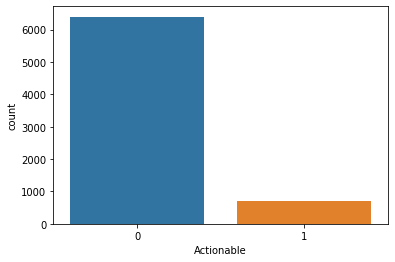

In [26]:
sns.countplot(x=target, data=df)

In [27]:
majority_class_indices = df[df[target] == 0].index
print(majority_class_indices)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7098, 7099, 7101, 7103, 7104, 7107, 7108, 7109, 7110, 7111],
           dtype='int64', length=6397)


In [28]:
minority_class_indices = df[df[target] == 1].index
print(minority_class_indices)

Int64Index([ 505,  507,  514,  518,  525,  526,  858,  926,  968,  976,
            ...
            7077, 7078, 7082, 7086, 7088, 7096, 7100, 7102, 7105, 7106],
           dtype='int64', length=715)


In [29]:
#only pick the number of majority class to be equal to minority
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

715


In [30]:
random_majority_indices

array([4195,  581,  871, 2342, 3039, 4776, 1299, 3575, 6960, 1356, 6927,
        316,  273, 4267, 3020, 6947, 5013, 5014, 2627, 4875, 6706,  732,
       1970, 3097, 3479, 6212, 6538, 3416, 4410, 5749, 2419, 5708, 4239,
       3806, 1153, 5503, 4363, 3158, 6314, 1501,  292, 5054, 5036, 1822,
        409, 3377,  660, 2573, 1224, 2326, 5112, 2158, 6519, 5316,  301,
       1113, 1521, 7104, 5408, 6638, 4744, 4298, 4027,  259, 5518, 1011,
        799, 1765,  166, 1508, 6744, 3913, 3180,  980, 5388, 2349,  631,
       6204, 2846, 3447, 4448, 2431, 4598, 5809, 6518, 2448, 4882,  919,
        194,  645, 5561, 6919, 6035, 1534,  548, 1879,   10, 1001, 4548,
       3282,  474, 5229, 4196, 1474, 6333, 2954, 6311, 2410,  711, 6055,
       6814,  131, 3008, 2221, 1562,  918, 5453, 1830, 4960,  853, 1184,
       4226, 3837, 3587, 4998, 5343, 4741, 6700, 6440,  496, 6847, 2126,
       4987, 3521, 1919,  220, 6372, 1290, 6561, 3435,  502, 1084, 3157,
       5366, 2184,  100, 4529, 1489, 5076, 3655, 60

In [31]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [32]:
under_sample = df.loc[under_sample_indices]

<AxesSubplot:xlabel='Actionable', ylabel='count'>

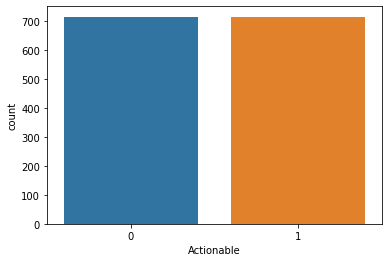

In [33]:
sns.countplot(x=target, data=under_sample)

In [34]:
under_sample

,Comments,Actionable
505,need in child,1
507,need are dp,1
514,problem need dp,1
518,doubt efficacy,1
525,wastage problem,1
...,...,...
6713,tier 3 academic feel there are subset in popul...,0
6954,tier 3 community leukemia oncology pharmacist ...,0
4630,agenda,0
5476,1 27 read,0


### Training and Testing

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [36]:
#new X and Y with undersampling
X = feature_df.loc[under_sample_indices]
Y = under_sample['Actionable']

In [37]:
#split training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [38]:
print('Training:', len(Y_train))
print('Testing:', len(Y_test))

Training: 1001
Testing: 429


In [39]:
#fit data with logistic regression
clf = LogisticRegression().fit(X_train, Y_train.values.ravel())
Y_Test_Pred = clf.predict(X_test)

In [44]:
Y_Test_Pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,

In [52]:
len(Y_Test_Pred)

429

In [40]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [41]:
generate_model_report(Y_test, Y_Test_Pred)

Accuracy =  0.7902097902097902
Precision =  0.7705627705627706
Recall =  0.827906976744186
F1 Score =  0.7982062780269058


In [42]:
#print actionable items- start by getting indices of original comments
#ind = indices of only actionable items
ind = []

for i in range(0, len(Y_Test_Pred)):
    item = Y_Test_Pred[i]
    if item == 1:
        ind.append(i)

comment_indices = []
for i in ind:
    comment_indices.append(X.iloc[i].name)

In [44]:
#indices of the cleaned data- next need to convert back to original indices
comment_indices

[505,
 514,
 518,
 526,
 968,
 976,
 1007,
 1318,
 1340,
 1343,
 1345,
 1360,
 1363,
 1372,
 1374,
 1376,
 1400,
 1406,
 1435,
 1440,
 1500,
 1519,
 1535,
 1603,
 1613,
 1631,
 1657,
 1674,
 1675,
 1686,
 1688,
 1703,
 1705,
 1706,
 1738,
 1787,
 1796,
 1798,
 1814,
 1828,
 1865,
 1866,
 1874,
 1900,
 1912,
 1922,
 1924,
 1947,
 1958,
 1960,
 1971,
 1973,
 1983,
 1984,
 1989,
 1993,
 1995,
 2013,
 2022,
 2024,
 2026,
 2040,
 2041,
 2047,
 2059,
 2087,
 2088,
 2091,
 2092,
 2094,
 2118,
 2124,
 2130,
 2140,
 2141,
 2143,
 2144,
 2160,
 2171,
 2174,
 2177,
 2186,
 2193,
 2225,
 2231,
 2255,
 2261,
 2263,
 2265,
 2267,
 2268,
 2273,
 2321,
 2324,
 2328,
 2330,
 2337,
 2414,
 2422,
 2466,
 2484,
 2485,
 2514,
 2563,
 2589,
 2600,
 2604,
 2618,
 2635,
 2640,
 2658,
 2687,
 2698,
 2716,
 2717,
 2724,
 2752,
 2783,
 2796,
 2801,
 2810,
 2815,
 2822,
 2827,
 2843,
 2845,
 2852,
 2871,
 2877,
 2893,
 2903,
 2908,
 2909,
 2910,
 2913,
 2916,
 2923,
 2945,
 2970,
 2971,
 2975,
 2976,
 2986,
 3003

In [45]:
#print out actionable items detected with ML!
act_lst = []

for i in comment_indices:
    index = new_ind[i]
    item = []
    item.append(index+1)
    item.append(dataset['Hcp Feedback'][index])
    act_lst.append(item)

for item in act_lst:
    print('{}. {}'.format(item[0], item[1]))

663. unmet need in children
677. problem with RDTL, we need DP
682. doubt about efficacy blina
694. wastage problem
1213. Dra Moirano is a member of the Subcomission of Acute Lymphoblastic leukemias of the Sociedad Argentina de Hematología, she is in charge of the Acute leukemias in Hospital San Martin de la Plata, she is very interested in the Blast PSA, trial becoause she has a great number of patients in the Hospital but she has an access issue , because main of them lacks of Health Insurance, we talk about the very favourable results of the paper Curative outcomes following blinatumomab in adults with minimal residual disease B-cell precursor acute lymphoblastic leukemia, Nicola Gökbuget,
1221. Dr Mosso consulted about Bliantumomab in Adults MRD +, as he is treatng a 20 year old female patient who has indicated HSCT SINCE 2019 but she could not do it because of administrative problems, in this time she started in 2017 with pediatric protocol and when she finished the maintenance tr

### Analysis by Country

In [62]:
act_countries = []

for item in act_lst:
    country = dataset['Interaction Territory Country'][item[0]]
    if country not in act_countries:
        act_countries.append(country)

In [63]:
act_countries

['Poland',
 'AR',
 'BR',
 'CA',
 'CO',
 'Gulf States',
 'Maghreb',
 'MX',
 'South Africa']

In [64]:
#get all countries in dataset
all_countries = []

for comment in dataset['Interaction Territory Country']:
    if comment not in all_countries:
        all_countries.append(comment)

In [65]:
#initializing dicts to all zeros
country_counts = dict.fromkeys(act_countries,0)
country_totals = dict.fromkeys(all_countries,0)

In [66]:
#get counts of actionable items in each country (some countries have none)
for item in act_lst:
    country = dataset['Interaction Territory Country'][item[0]]
    country_counts[country] +=1

In [67]:
country_counts

{'Poland': 4,
 'AR': 3,
 'BR': 96,
 'CA': 14,
 'CO': 37,
 'Gulf States': 3,
 'Maghreb': 42,
 'MX': 12,
 'South Africa': 2}

In [68]:
#get totals for each country
for comment in dataset['Interaction Territory Country']:
    country_totals[comment] +=1

In [69]:
percent_actionable = {}
for (key,value) in country_totals.items():
    if key in country_counts:
        percent_actionable[key] = country_counts[key]/value * 100

In [70]:
percent_actionable

{'Poland': 4.878048780487805,
 'AR': 0.5952380952380952,
 'BR': 6.911447084233262,
 'CA': 7.253886010362693,
 'CO': 12.131147540983607,
 'Gulf States': 1.1952191235059761,
 'Maghreb': 5.691056910569105,
 'MX': 2.510460251046025,
 'South Africa': 5.0}

### Apply to XGEVA Dataset - Test!

In [46]:
#Read in dataset
new_dataset = pd.read_csv('xgeva_interactions.csv', na_filter=False)
#only look at comments and tags
new_dataset = new_dataset[['interaction_dt', 'hcp_comments']]
print(new_dataset)

      interaction_dt                                       hcp_comments
0          6/25/2020  We talked about risk of hypocalcemia in patien...
1           9/2/2020                              XGEVA safety aspects.
2          11/7/2020  Lung cancer is the second cancer in men, 3000 ...
3          3/17/2021  Xgeva is not cost-effective when compared to z...
4           7/6/2020  We talked about the ONJ incidence and about th...
...              ...                                                ...
30013     11/16/2020  Invitation and preparation for MDT management ...
30014     11/30/2020  140 patients until now from 2015 (treated with...
30015      6/23/2021                              CTIBL prostate cancer
30016     11/12/2020                                                   
30017     10/13/2020                                                   

[30018 rows x 2 columns]


In [47]:
#clean data
new_cleaned_data = []
new_indices = []

for i in range(0, len(new_dataset['hcp_comments'])):
    
    comment = re.sub('[^a-zA-Z0-9]' , ' ' , new_dataset['hcp_comments'][i])
    #comment = translator.translate(comment).text
    comment = comment.lower()
    comment = comment.split()
 
    wl = WordNetLemmatizer()
    comment = [wl.lemmatize(word) for word in comment] #if not word in set(stopwords.words('english'))]
    comment = [w for w in comment if wordnet.synsets(w,pos='n',lang='eng')]
    comment = ' '.join(comment)
    new_cleaned_data.append(comment)
    new_indices.append(i)

In [48]:
#remove comments that are blank after cleaning
new_processed_data = []
new_processed_ind = []

for i in range(0, len(new_cleaned_data)):
    comment = new_cleaned_data[i]
    if comment:
        new_processed_data.append(comment)
        new_processed_ind.append(new_indices[i])

In [49]:
len(new_processed_data)

13155

In [52]:
tfidf = TfidfVectorizer()
tfidf.fit(processed_data)

dense = t.transform(new_processed_data).todense()
denselist = dense.tolist()
new_feature_df = pd.DataFrame(denselist, columns=feature_names)

In [53]:
new_feature_df

,10,100,1000,10000,100000,11,12,13,14,15,...,year,yes,yesterday,yield,york,young,yr,zill,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
X_test = new_feature_df
print(X_test.shape)

(13155, 3209)


In [55]:
#training will be from previous dataset only
X_train = feature_df
print(X_train.shape)
Y_train = Y = df['Actionable']
print(Y_train.shape)

(7112, 3209)
(7112,)


In [56]:
clf = LogisticRegression().fit(X_train, Y_train.values.ravel())
Y_Test_Pred = clf.predict(X_test)

In [62]:
#print actionable items- start by getting indices of original comments
#ind = indices of only actionable items
ind = []

for i in range(0, len(Y_Test_Pred)):
    item = Y_Test_Pred[i]
    if item == 1:
        ind.append(i)

comment_indices = []
for i in ind:
    comment_indices.append(X_test.iloc[i].name)

In [66]:
#print out actionable items detected with ML!
#remove duplicates
act_lst = []

for i in comment_indices:
    index = new_processed_ind[i]
    item = []
    item.append(index+1)
    item.append(new_dataset['hcp_comments'][index])
    act_lst.append(item)


print_lst = []
for item in act_lst:
    if item[1] not in print_lst:
        print('{}. {}'.format(item[0], item[1]))
    print_lst.append(item[1])

167. There are 2 patients being treated with denosumab.
461. There are 2 patients being treated with Denosumab.
638. â—‹ Frequency of dosing: 
		â—‹ patients are willing to take a monthly therapy for the first year, but after the first year they need less frequent dosing.  Quote: "This is very, very important. No one wants to be here more than every two weeks, ideally no more often than every 4 weeks"  
		â—‹ Q1wk dosing is not clinically preferred, especially if there is a Q3wk option
		â—‹ XGEVA mentioned, and Dr. Kumar said that Mayo uses anti-resorptives every 3 months as an example.
816. Still catching up on surgery backlog due to COVID-19, but currently there is little impact of the pandemic on his practice. Patients are able to get treatment and denosumab injections are not an issue.
2031. Xgeva could more consideration because of its efficacy, ease of administration and less severe side effects. The data of QOL showed benefit. However limitation of cost ,doctors would need to b